# Tutorial 1 - Particle sizing

Welcome to the first tutorial of this series! In this notebook, we'll explore one of the simplest yet insightful applications of Differential Dynamic Microscopy (DDM): particle sizing. Throughout this exploration, we'll be assisted by **fastDDM**.

Whether you're a seasoned researcher in the field of soft matter physics or a curious enthusiast, this notebook aims to provide a hands-on experience in leveraging DDM to uncover the hidden dynamics within colloidal systems.

### Purpose

The goal of this tutorial is to guide you through the fundamental principles of particle sizing using DDM. Specifically, we will:

1. Load microscopy image sequences of colloidal particle suspensions undergoing Brownian motion.
2. Obtain the corresponding structure functions using DDM.
3. Calculate the azimuthal average of the structure functions.
4. Fit the azimuthal average to gain insights into the sample's dynamics.
5. Convert the dynamical properties into particle size.

This tutorial assumes that you have a basic understanding of the features offered by fastDDM. If you need a refresher, consider reviewing the previous [tutorial ("zero")](../Tutorial_0-Introduction/tutorial0.ipynb).

## Setting up your workspace

Before we dive into the analysis, make sure you have **fastDDM** and the required scientific analysis, fitting, and visualization packages installed on your machine. Refer to the main [README](../README.md) for installation instructions.

For this tutorial, we'll be using [open-source microscopy videos](https://datashare.ed.ac.uk/handle/10283/4858) provided with the paper [Bradley et al, *Soft Matter*, 2023, **19**, 8179](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c). If you haven't done so already, download the files and unzip the main folder (and the `Video_dataset.zip` within it) in the directory containing these tutorials.

Your main directory tree should resemble the following:
```
.
├── DS_10283_4858
│   └── Video_dataset
│       └── third_vid_dataset
├── Tutorial_0-Introduction
└── Tutorial_1-Particle_sizing
```

## Samples description

The samples under study consist of dilute solutions of polystyrene (PS) spheres with various sizes dispersed in Milli-Q water.
The batches, obtained from Thermo Scientific (5000 series), have diameters ranging from 60 nm to 2.1 $\mu$m.
These samples are prepared at a volume fraction $\phi=10^{-5}$ and loaded into 0.4 $\times$ 4 $\times$ 50 mm glass capillaries (Vitrocom).
For more details, refer to the [full article](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c).

## Let's get started

Now that the stage is set, let's begin by importing some essential libraries, including `fastddm`.

In [1]:
%matplotlib notebook

import gc
import os
import lmfit
import numpy as np

# set numpy print options to limit the length of the output
np.set_printoptions(threshold=0)

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

# get rid of the 'too many open images' warning
mpl.rcParams.update({'figure.max_open_warning': 0})

# color space helper
def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

# fastddm
import fastddm as fd
from fastddm.fit import fit

Here, we define the paths to the videos and the labels indicating the nominal particle size.

In [2]:
# directory containing the videos
main_directory = '../DS_10283_4858/Video_dataset/third_vid_dataset/27_07_2021_BF_Scaling_Neat/'

# file names (including enclosing folder)
file_names = [
    'BF20x_1x1_200fps_Pos3_3/BF20x_1x1_200fps_Pos3_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos1_3/BF20x_1x1_200fps_Pos1_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos4_3/BF20x_1x1_200fps_Pos4_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos0_3/BF20x_1x1_200fps_Pos0_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos5_3/BF20x_1x1_200fps_Pos5_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos2_3/BF20x_1x1_200fps_Pos2_3_MMStack_Default.ome.tif',
]

# create full paths
file_paths = [os.path.join(main_directory, fn) for fn in file_names]

# list of labels
labels = [
    '60 nm',
    '120 nm',
    '240 nm',
    '500 nm',
    r'1.1 $\mu$m',
    r'2.1 $\mu$m',
]

The experimental parameters are listed in Sec. 4 of the reference [paper](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c).
Videos are acquired at 200 fps with a Hamamatsu Orca Flash 4.0 camera (pixel size 6.5 $\mu$m) using a 20$\times$, NA 0.5 objective. This gives an effective pixel size of $\delta_{px} = 6.5/20 \, {\mu\mathrm{m}} = 325 \, \mathrm{nm}$.

In [3]:
# experimental parameters
frame_rate = 200       # frames per second
pixel_size = 6.5/20    # microns per pixel

It's always useful to begin by inspecting the videos. We'll load the first frame from each movie and display the images in a grid.

<IPython.core.display.Javascript object>


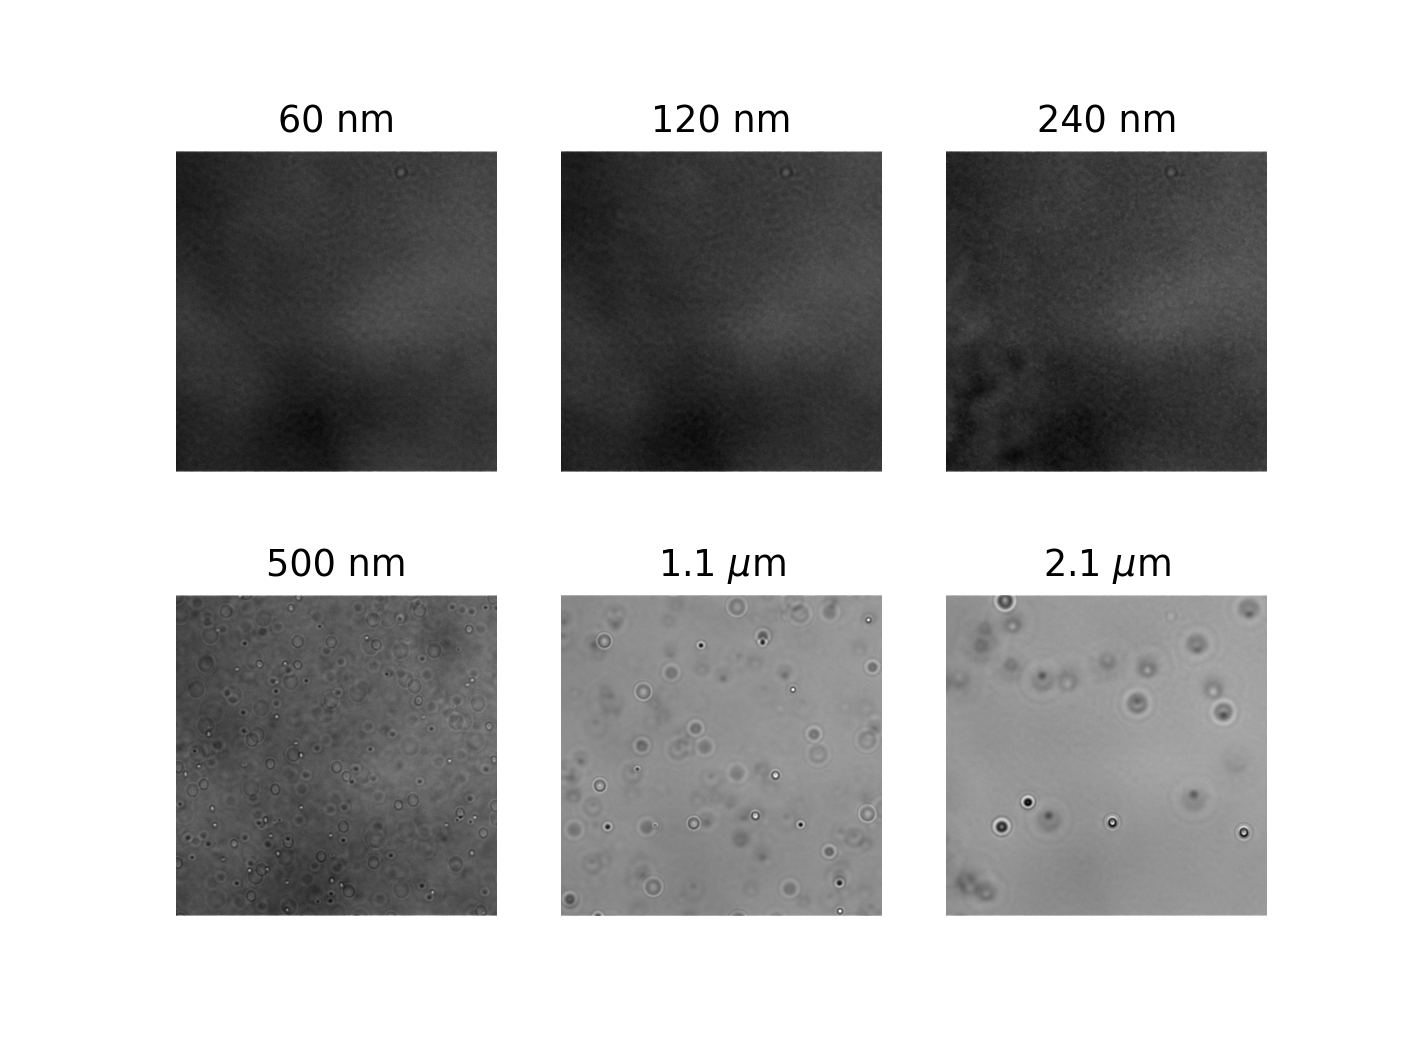

In [4]:
fig = plt.figure()
fig.tight_layout()
gs = fig.add_gridspec(ncols=3, nrows=2)
axs = gs.subplots()

# read the images
images = []
for path in file_paths:
    images.append(fd.read_images(path, seq=[0]))

for ax, img, label in zip(axs.flatten(), images, labels):
    ax.imshow(img, cmap='gray')
    
    ax.set_axis_off()
    ax.set_title(label)

Observe that the particles are visible only in the lower panels (500 nm to 2.1 $\mu$m), whereas they remain indiscernible in the upper panels due to their size being too small to be optically resolved.

## Structure function and azimuthal average calculation

The structure function stands as a foundation tool for unveiling spatial correlations and dynamic features within images. For samples having an isotropic dynamics, the statistics can be enhanced by calculating the azimuthal average of the structure function.

In order to save space in the memory, after the calculation of the azimuthal average we will delete the structure functions and the image sequences. We will not use them afterwards.

The process for the calculation for each image sequence is as follows:

1. **Data preparaton:** We initiate the process by loading the image sequence from the file.
2. **Structure function calculation:** We apply DDM to the image sequence to derive the structure function.
3. **Azimuthal average calculation:** We will calculate the azimuthal average of the structure function and store it in a list for later use.
4. **Delete unused variables:** Finally, we will delete the image sequence and the structure function, keeping only the azimuthal average.

Use the following cell to select the `core` and `mode` you want to use for the calculation of the structure function. Keep in mind that:

* `fft` is (way) faster than `diff`
* `cuda` is faster than `cpp` which is faster than `py`
* `py` is always available

In [5]:
### UNCOMMENT THE CORE YOU WISH TO USE ###
#CORE = 'py'
#CORE = 'cpp'
CORE = 'cuda'

### UNCOMMENT THE MODE YOU WISH TO USE ###
#MODE = 'diff'
MODE = 'fft'

In [6]:
print('--- Calculating structure functions and azimuthal averages... ---')

aa = []

for num, f in enumerate(file_paths):
    # notify user on progress
    print(f'Analyzing movie #{num+1} of {len(file_paths)} ...')
    
    # read image sequence
    img_seq = fd.read_images(f)
    
    # compute structure function
    lags = range(1, int(len(img_seq) / 2))              # we analyze delays only up to half the length of the video
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size
    dqt.set_frame_rate(frame_rate)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                       # number of bins
    bin_range = (0, dqt.ky[-1])                       # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
    aa.append(fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm))
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()

--- Calculating structure functions and azimuthal averages... ---
Analyzing movie #1 of 6 ...
Analyzing movie #2 of 6 ...
Analyzing movie #3 of 6 ...
Analyzing movie #4 of 6 ...
Analyzing movie #5 of 6 ...
Analyzing movie #6 of 6 ...


Only for the purpose of visualization, we also create a resampled azimuthal average using logarithmically-spaced time delays.

In [7]:
aa_resampled = []

for a in aa:
    new_taus = fd.lags.logspace_int(len(a.tau), num=100, endpoint=True) * a.tau[0]
    aa_resampled.append(a.resample(new_taus))

### Estimate noise and amplitude

In [8]:
# estimate noise and amplitude terms
Bq = []
Aq = []

for a in aa:
    # estimate noise term using the 'polynomial' method
    B_est, _ = fd.noise_est.estimate_camera_noise(a, mode='polyfit', num_points=5)
    Bq.append(B_est)
    
    # estimate total amplitude
    Aq_plus_Bq = 2 * a.var
    
    # estimate static amplitude 
    Aq.append(Aq_plus_Bq - B_est)

### Fit with simple exponential

In [9]:
from fastddm.fit import fit_multik
from fastddm.fit_models import simple_exponential_model as model

# choose reference k vector
k_ref = 20

To initiate a fitting process with a reliable starting value for the relaxation rate, we can estimate $\tau = 1/\Gamma$ by first estimating the intermediate scattering function and determining the delay where it has a value of $1/\mathrm{e}$.

In [10]:
# initialize lists
fit_res = []
model_res = []

for a, B, A in zip(aa, Bq, Aq):
    # estimate intermediate scattering function at `k_ref`
    fqt = 1 - (a.data[k_ref] - B[k_ref]) / A[k_ref]
    
    # estimate Gamma
    tau = a.tau[np.argmin(np.abs(fqt - np.exp(-1)))]
    Gamma0 = 1 / tau
    
    # set model parameters hints
    model.set_param_hint('A', value=A[k_ref])
    model.set_param_hint('B', value=B[k_ref])
    model.set_param_hint('Gamma', value=Gamma0)
    
    # fit
    fr, mr = fit_multik(a, model, k_ref, use_err=True, return_model_results=True)
    fit_res.append(fr)
    model_res.append(mr)

Show fit results (intermediate scattering functions).

<IPython.core.display.Javascript object>


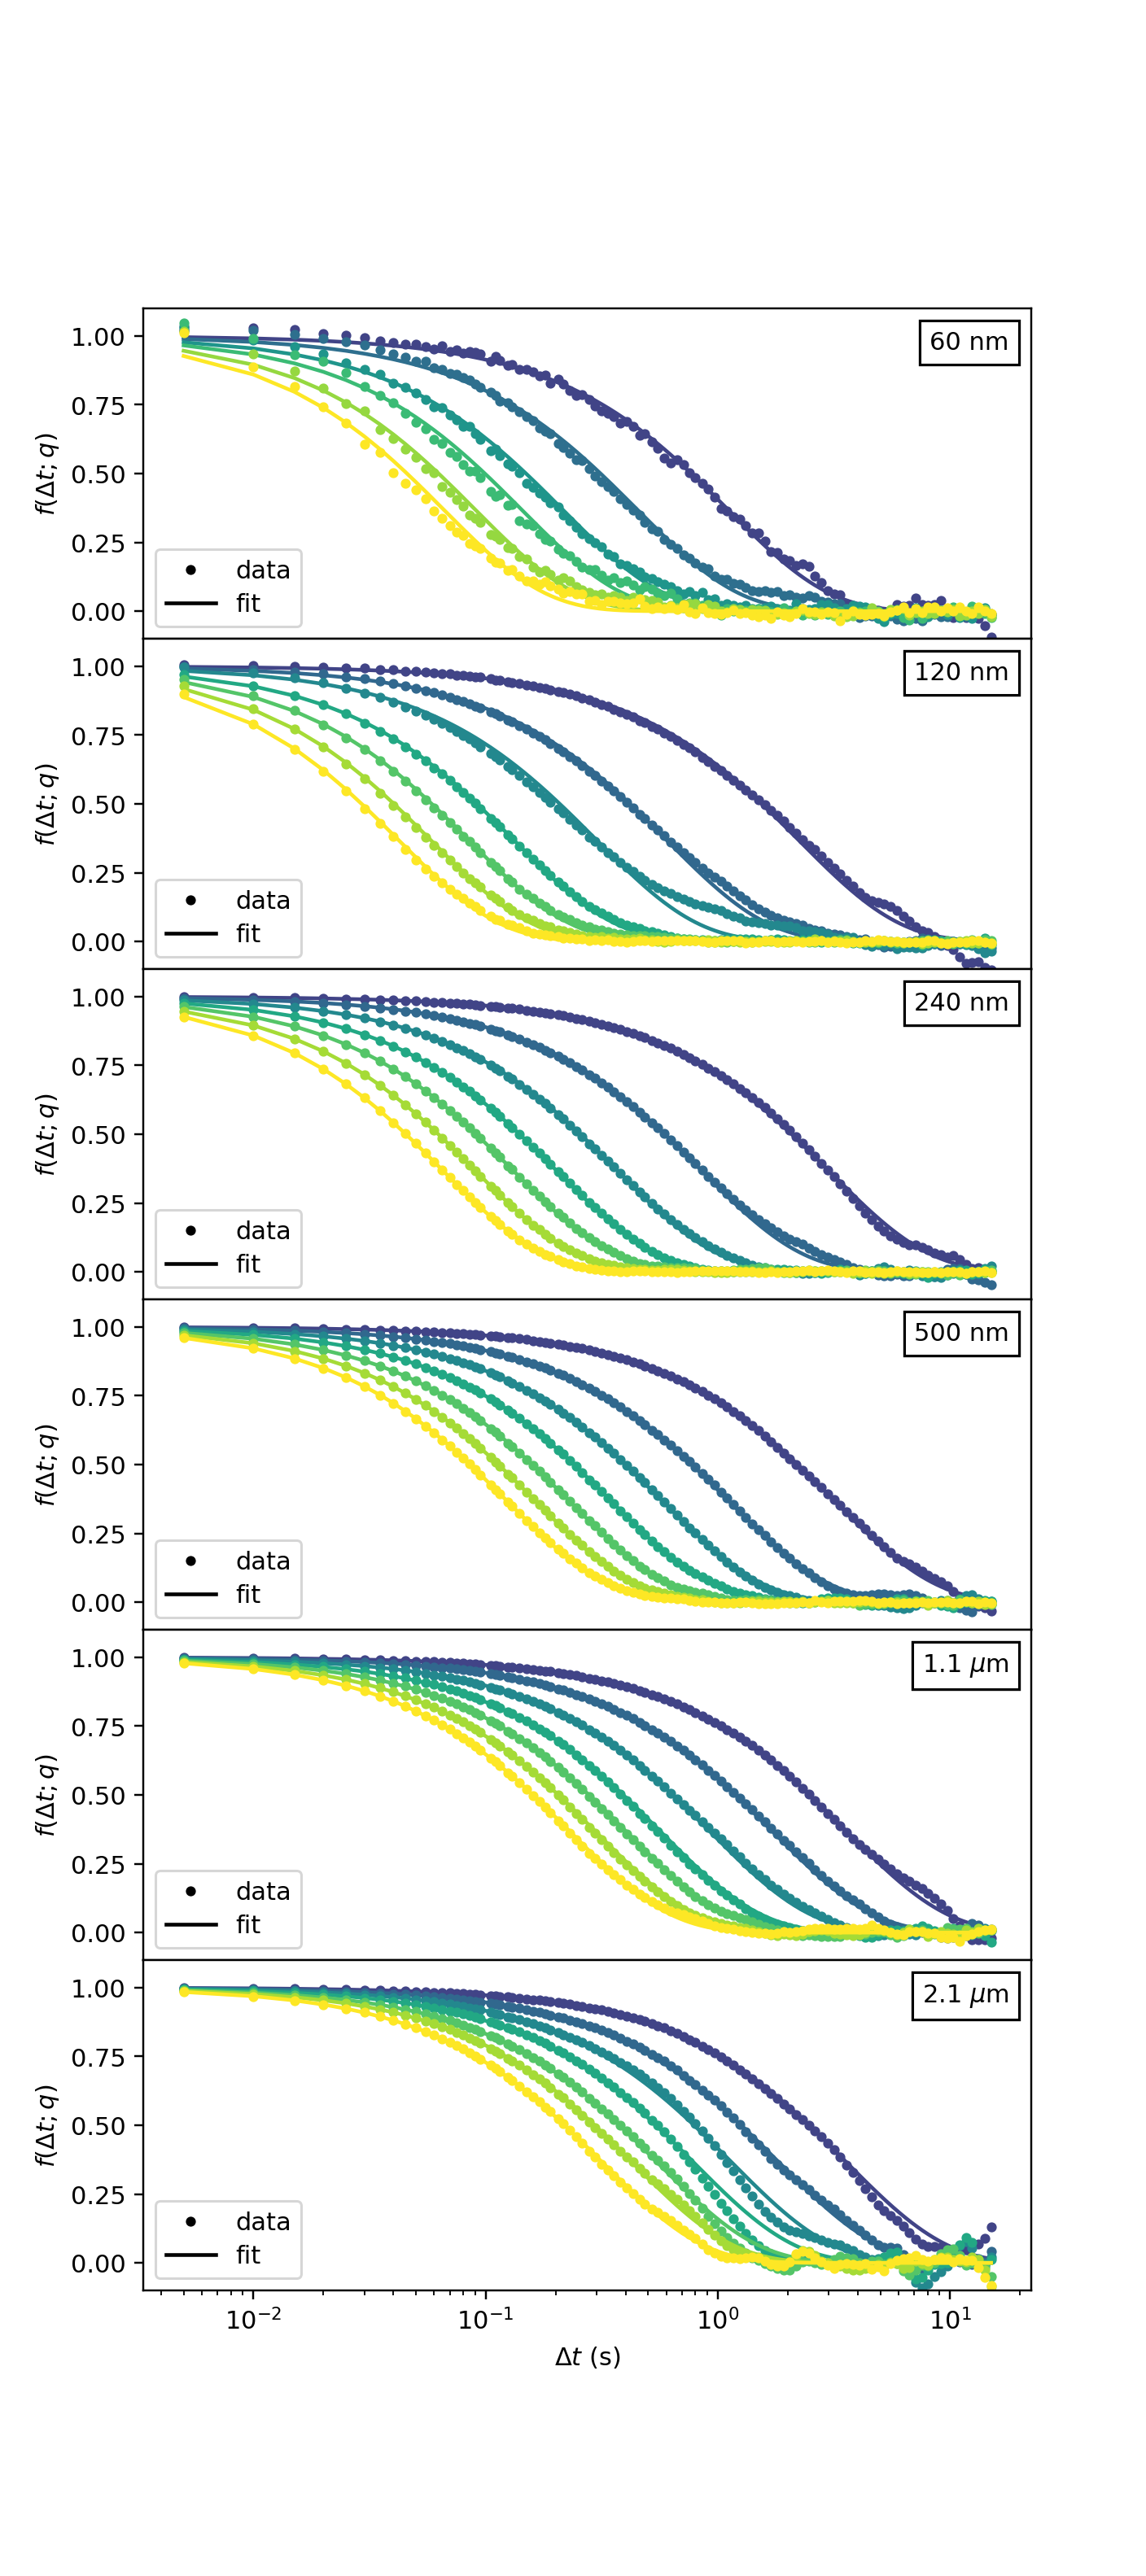

In [18]:
fig = plt.figure()
fig.tight_layout()
fig.set_figheight((len(aa) / 2) * fig.get_figheight())
gs = fig.add_gridspec(len(aa), hspace=0)
axs = gs.subplots(sharex=True)

# select range of wave vector indices
k_min = [10, 10, 10, 15, 20, 30]
k_max = [50, 80, 80, 80, 90, 100]
k_step = [7, 10, 10, 10, 10, 10]

k_range = [range(k_m, k_M, k_s) for k_m, k_M, k_s in zip(k_min, k_max, k_step)]

# plot curves
for ax, a, ar, fr, mr, kr, l in zip(axs, aa, aa_resampled, fit_res, model_res, k_range, labels):
    cspace = color_space(len(kr))
    
    for k_idx, c in zip(kr, cspace):
        # calculate intermediate scattering function
        fqt = 1 - (ar.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
        fqt_fit = 1 - (mr[k_idx].best_fit - fr['B'][k_idx]) / fr['A'][k_idx]
    
        # plot
        ax.plot(ar.tau, fqt, '.', color=c)
        ax.plot(a.tau, fqt_fit, '-', color=c)
        
        # misc
        ax.set_ylabel(r'$f(\Delta t; q)$')
        ax.set_ylim(-0.1, 1.1)
        # label
        at = AnchoredText(l, prop=dict(size=10), frameon=True, loc='upper right')
        ax.add_artist(at)
        # custom legend
        custom_lines = [
            Line2D([0], [0], marker='.', linestyle='none', color='black', label='data'),
            Line2D([0], [0], linestyle='-', color='black', label='fit'),
        ]
        ax.legend(handles=custom_lines, labelspacing=0.4, loc='lower left')
        
axs[-1].set_xscale('log')
axs[-1].set_xlabel(r'$\Delta t$ (s)');

Show fit parameters ($\Gamma$ and $A$/$B$).

<IPython.core.display.Javascript object>


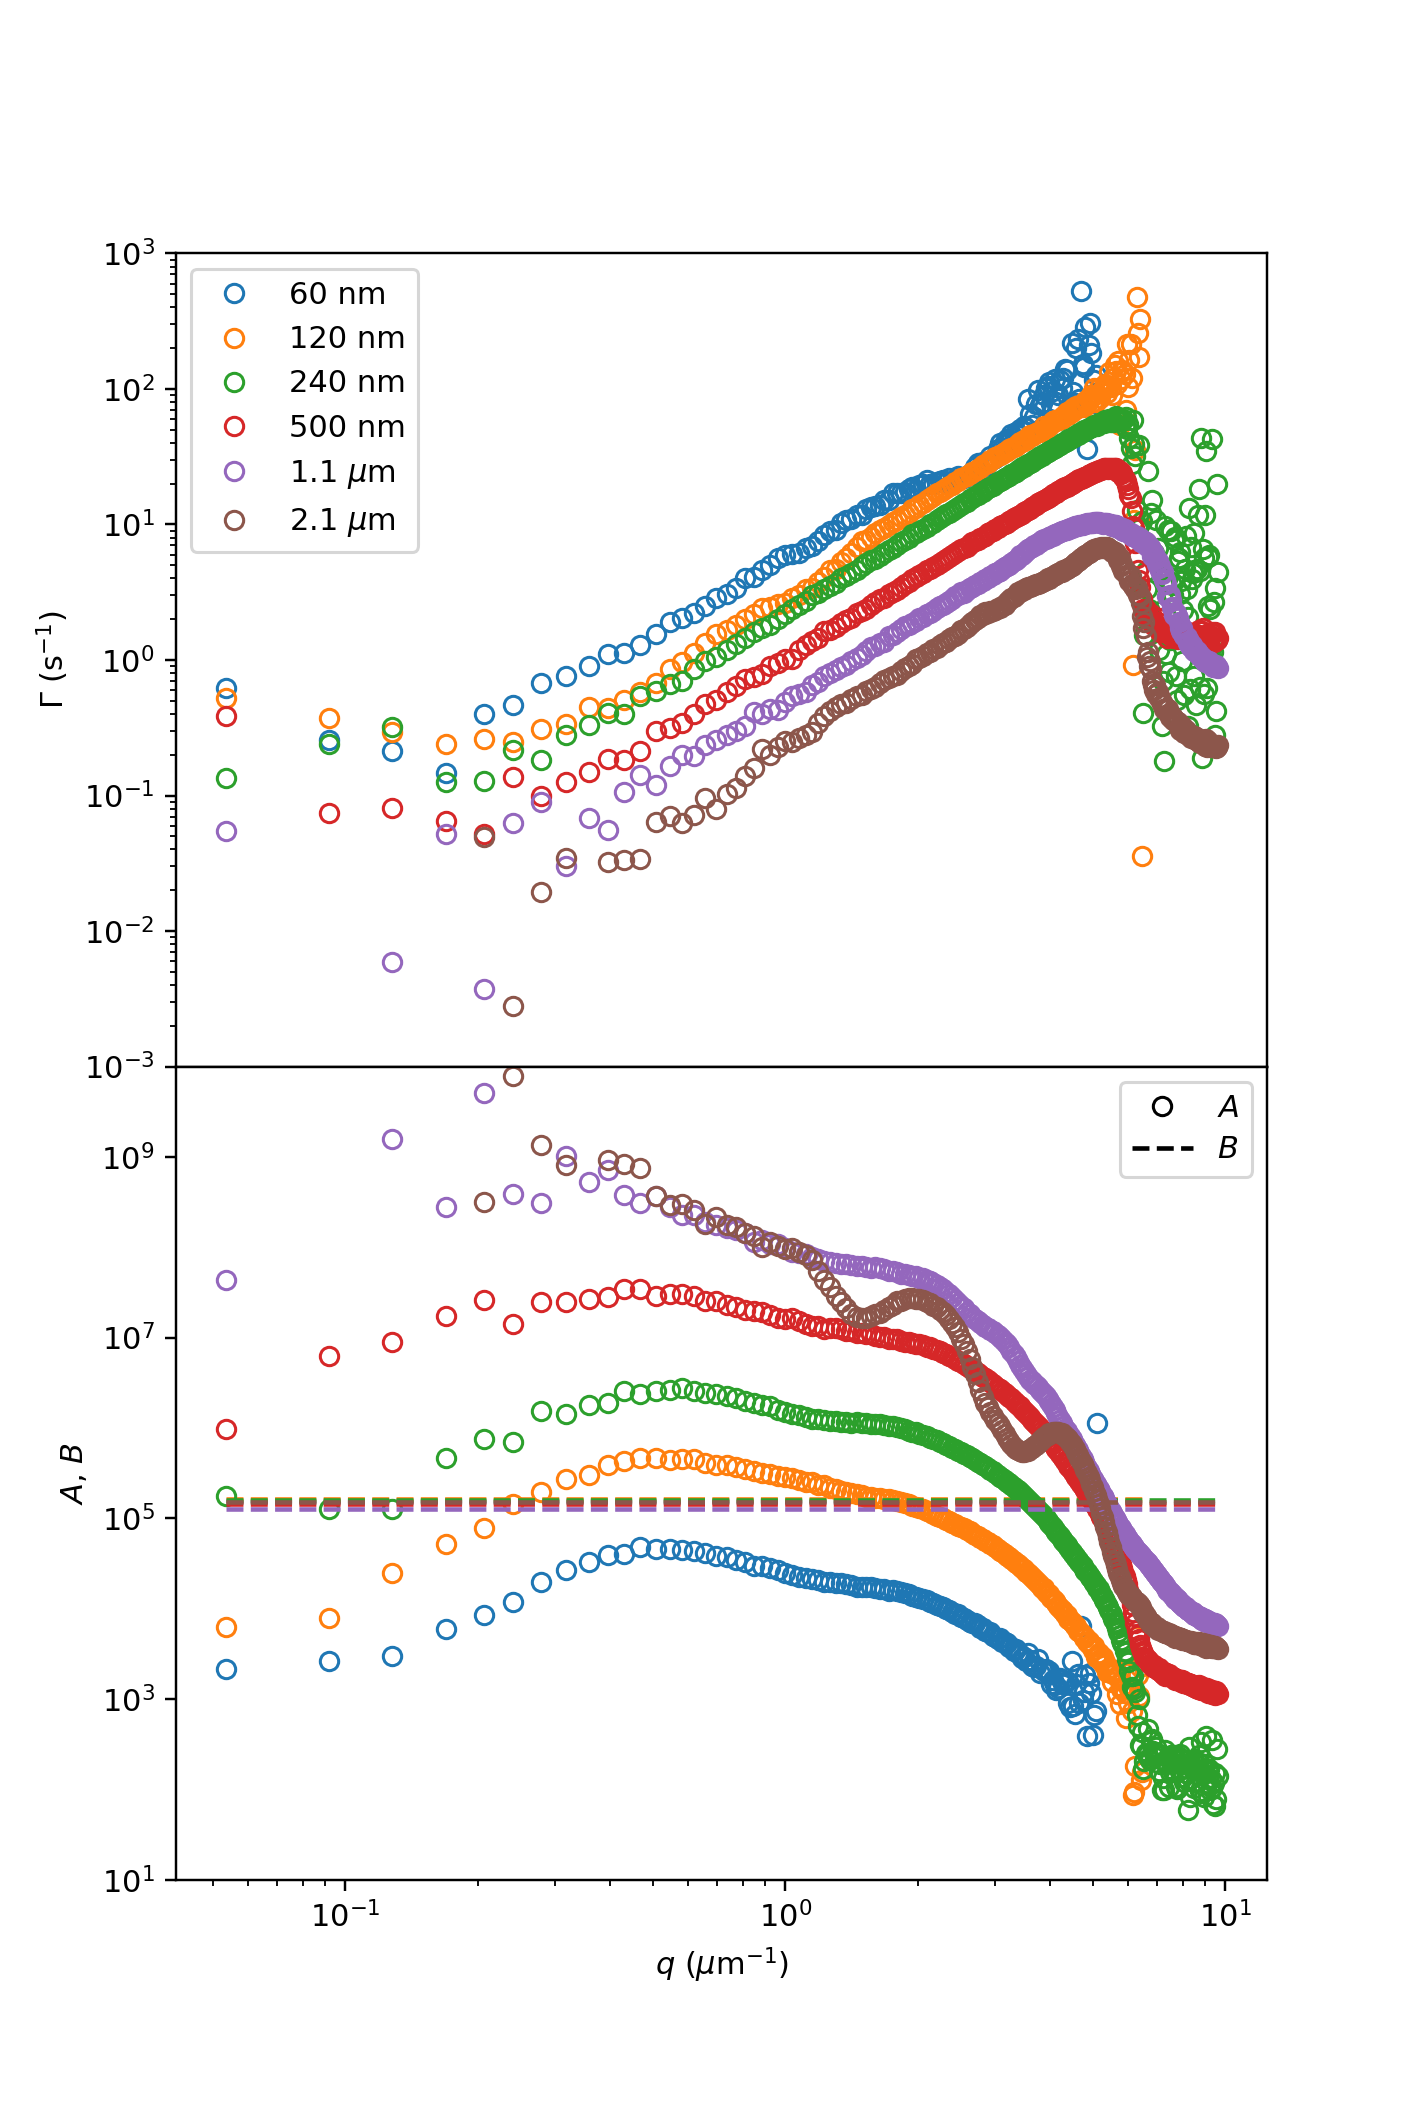

In [34]:
fig = plt.figure()
fig.tight_layout()
fig.set_figheight(2 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

for n, (fr, label) in enumerate(zip(fit_res, labels)):
    fr_filtered = fr[fr['success']].dropna()
    axs[0].plot(fr_filtered['k'], fr_filtered['Gamma'], f'C{n}o', markerfacecolor='none', label=label)
    axs[1].plot(fr_filtered['k'], fr_filtered['A'], f'C{n}o', markerfacecolor='none')
    axs[1].plot(fr_filtered['k'],
                np.full_like(fr_filtered['B'], fill_value=fr_filtered['B'].mean()),
                f'C{n}--')
    
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].set_ylim(1e-3, 1e3)
axs[0].legend()
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
axs[1].set_ylim(1e1, 1e10)
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none', color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right');

Limits of the analysis

$$
q_{\mathrm{min}} = \frac{2 \pi}{L}
$$

$$
q_{\mathrm{max}} = \frac{2 \pi \mathrm{NA}_o}{\lambda}
$$

$$
\gamma_T = 1 / \Delta t_{\mathrm{max}}
$$

$$
\gamma_0 = 1 / \Delta t_{\mathrm{min}}
$$

<IPython.core.display.Javascript object>


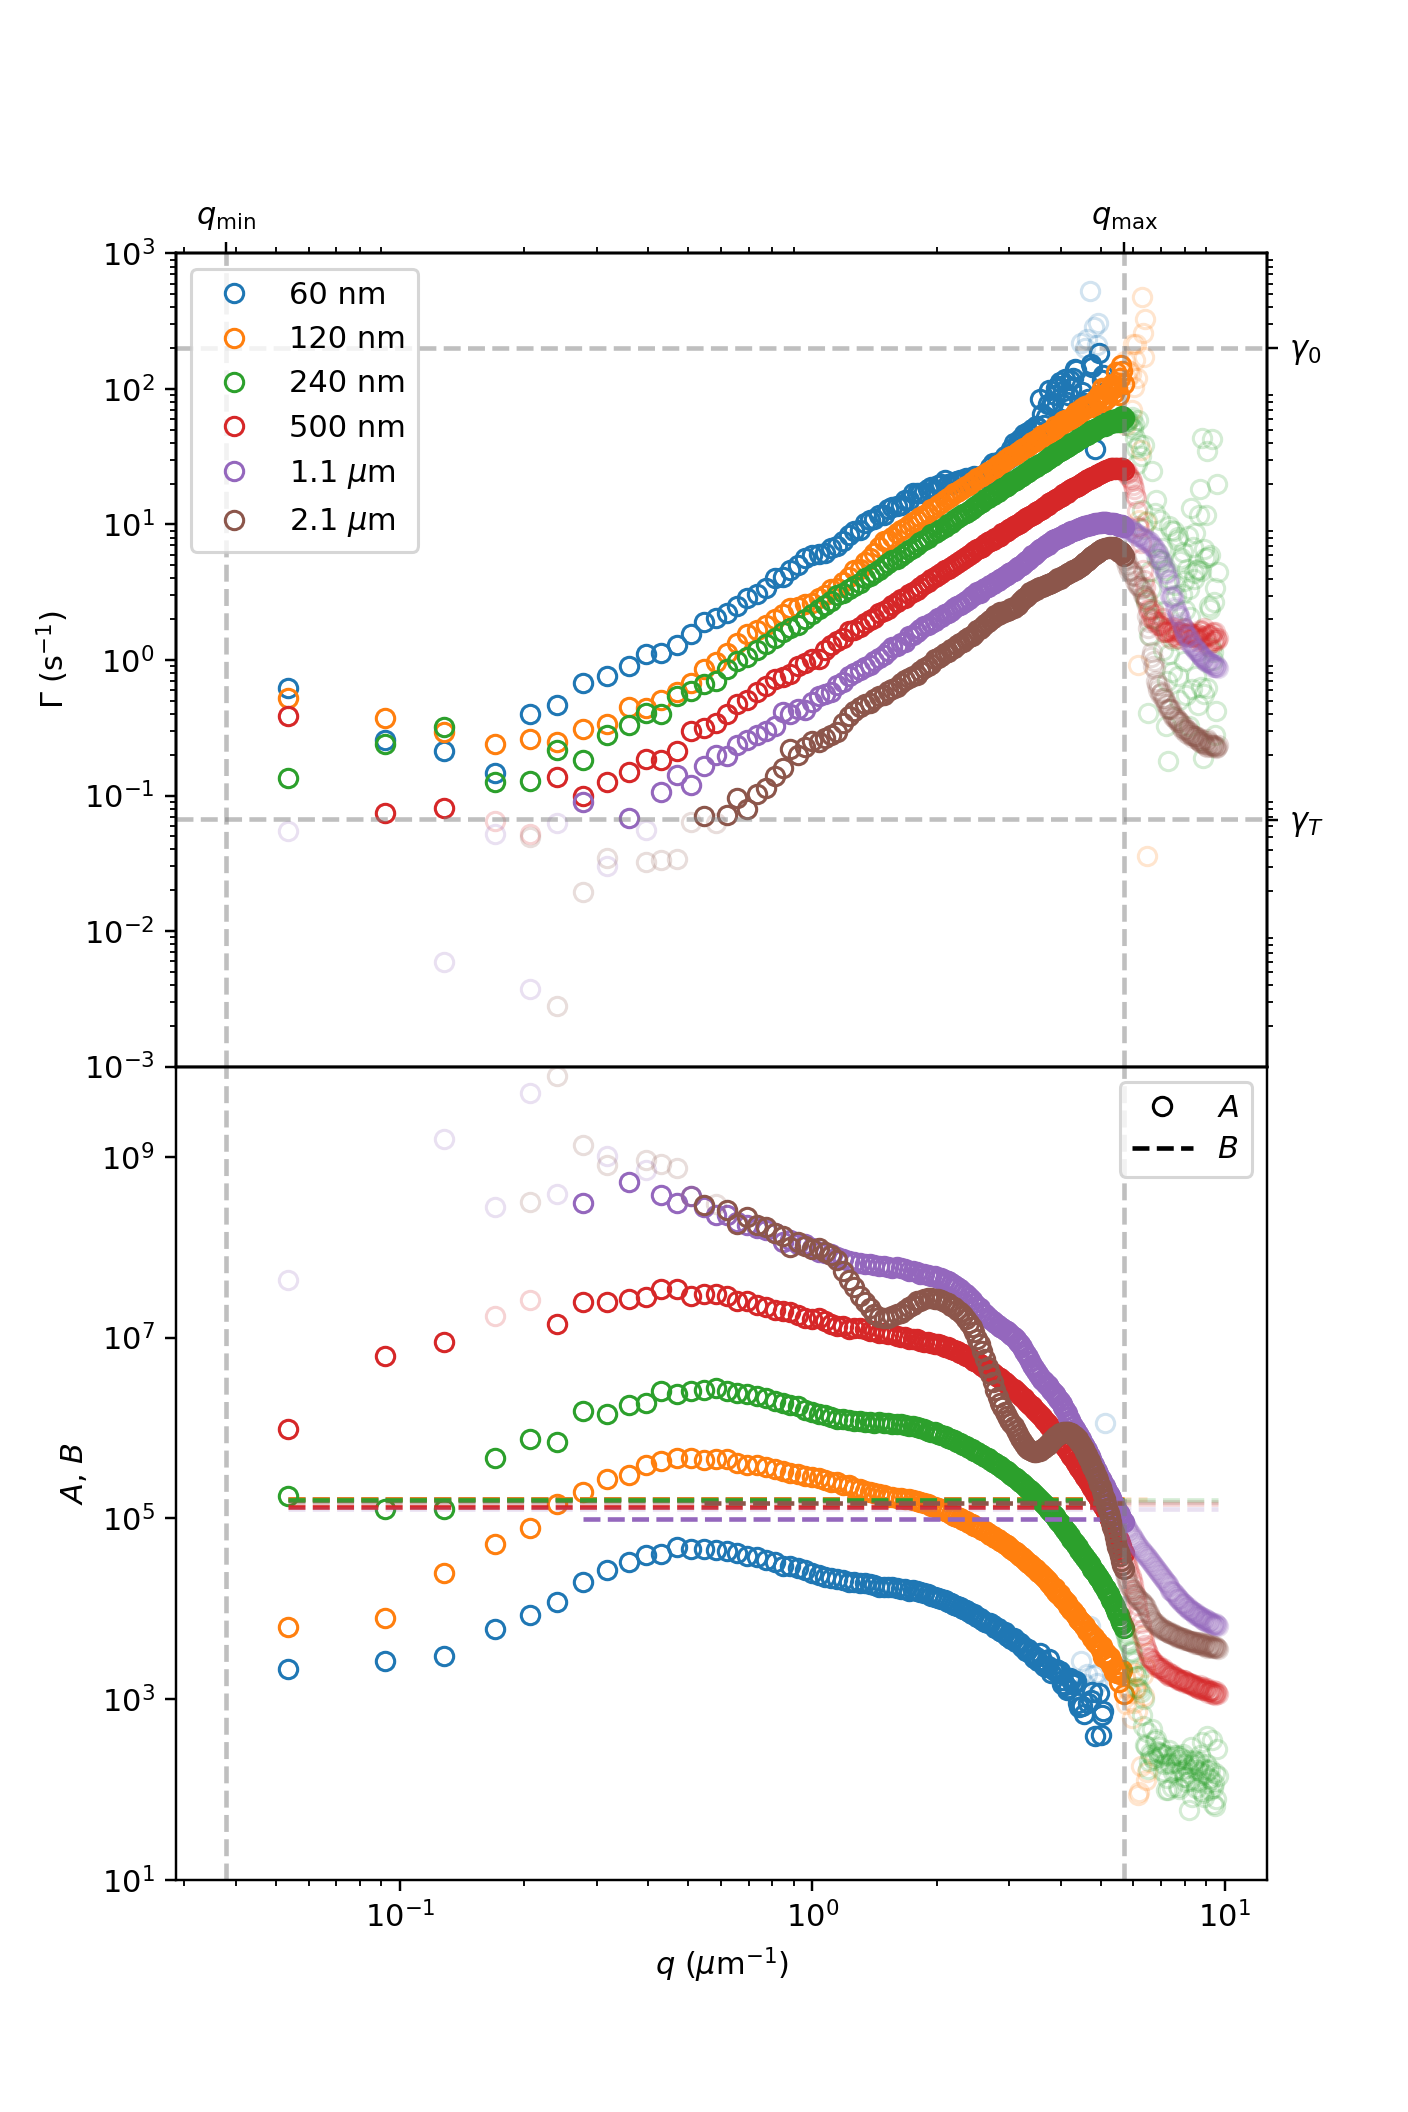

In [39]:
fig = plt.figure()
fig.tight_layout()
fig.set_figheight(2 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# optical parameters
L = pixel_size * 512
NAo = 0.5
lambda0 = 0.55

# limits
q_min = 2 * np.pi / L
q_max = 2 * np.pi * NAo / lambda0
gamma_T = 1 / aa[0].tau[-1]
gamma_0 = 1 / aa[0].tau[0]    # also, gamma_0 = frame_rate

# plot
for n, (fr, label) in enumerate(zip(fit_res, labels)):
    fr_filtered = fr[fr['success']].dropna()
    # filter q
    fr_filtered2 = fr_filtered[(fr_filtered['k'] >= q_min) & (fr_filtered['k'] <= q_max)]
    # filter gamma
    fr_filtered2 = fr_filtered2[(fr_filtered2['Gamma'] >= gamma_T) & (fr_filtered2['Gamma'] <= gamma_0)]
    
    # display the full data (with transparency)
    axs[0].plot(fr_filtered['k'], fr_filtered['Gamma'], f'C{n}o', markerfacecolor='none', alpha=0.2)
    axs[1].plot(fr_filtered['k'], fr_filtered['A'], f'C{n}o', markerfacecolor='none', alpha=0.2)
    axs[1].plot(fr_filtered['k'],
                np.full_like(fr_filtered['B'], fill_value=fr_filtered['B'].mean()),
                f'C{n}--', alpha=0.2)
    
    # display the filtered data
    axs[0].plot(fr_filtered2['k'], fr_filtered2['Gamma'], f'C{n}o', markerfacecolor='none', label=label)
    axs[1].plot(fr_filtered2['k'], fr_filtered2['A'], f'C{n}o', markerfacecolor='none')
    axs[1].plot(fr_filtered2['k'],
                np.full_like(fr_filtered2['B'], fill_value=fr_filtered2['B'].mean()),
                f'C{n}--')

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].set_ylim(1e-3, 1e3)
axs[0].legend()
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
axs[1].set_ylim(1e1, 1e10)
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none', color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')    

# plot Gamma limits
axs[0].axhline(gamma_T, color='gray', linestyle='--', alpha=0.5)
axs[0].axhline(gamma_0, color='gray', linestyle='--', alpha=0.5)

axtwin = axs[0].twinx()
axtwin.set_yscale('log')
axtwin.set_ylim(1.01e-3, 1e3)
yticks = [gamma_T, gamma_0]
yticklabels = [r'$\gamma_T$', r'$\gamma_0$']
axtwin.set_yticks(yticks)
axtwin.set_yticklabels(yticklabels)

# plot q limits
axs[0].axvline(x=q_min, color='gray', linestyle='--', alpha=0.5)
axs[0].axvline(x=q_max, color='gray', linestyle='--', alpha=0.5)
axs[1].axvline(x=q_min, color='gray', linestyle='--', alpha=0.5)
axs[1].axvline(x=q_max, color='gray', linestyle='--', alpha=0.5)

axtwinx = axs[0].twiny()
axtwinx.set_xscale('log')
xticks = [q_min, q_max]
xticklabels = [r'$q_{\mathrm{min}}$', r'$q_{\mathrm{max}}$']
axtwinx.set_xticks(xticks)
axtwinx.set_xticklabels(xticklabels)
axtwinx.set_xlim(axs[1].get_xlim());